In [2]:
#Import Modules

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Load Dataset

In [4]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4RR9VG_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4RR9VG_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [5]:
info   #info function gives you a quick summary of the dataset

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [6]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
#Preprocessing Steps

In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1 # convert to zero based indexing
    return input_image, input_mask

def load_train_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [9]:
#train test split

In [10]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
#Feature engineering

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
#Explanatory Data Analysis (EDA)

In [14]:
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

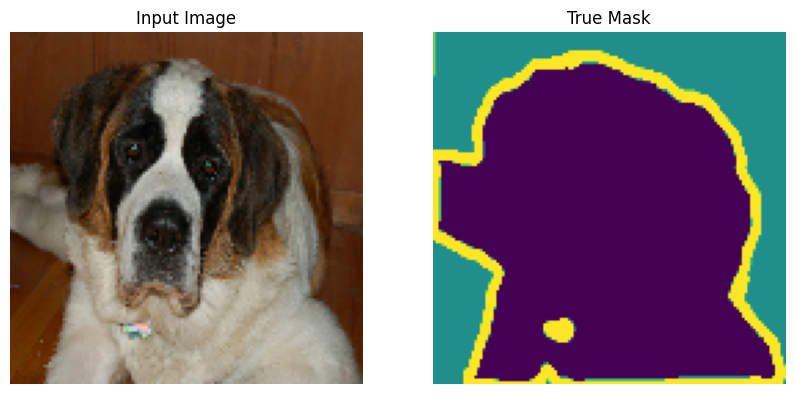

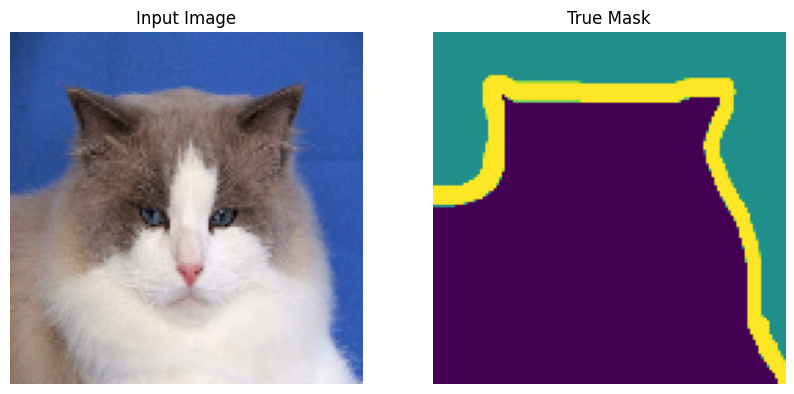

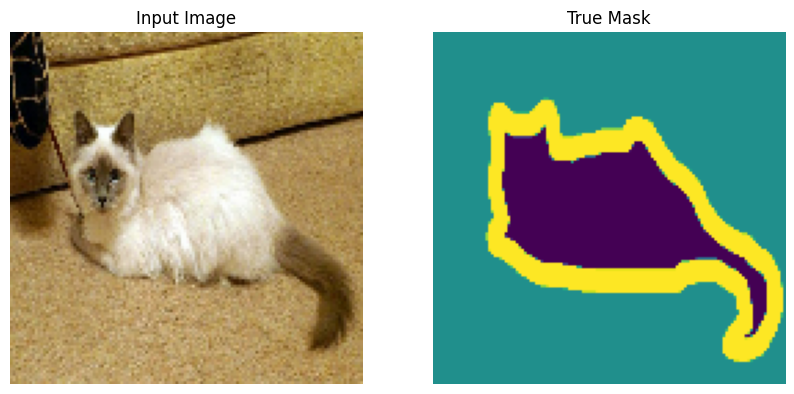

In [15]:
for images, masks in train_dataset.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

In [16]:
#Define U-Net Model

In [17]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [18]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # intermediate block
    intermediate_block = double_conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

In [19]:
# for images, masks in train_dataset.take(1):
#     sample_image, sample_mask = images[0], masks[0]
# sample_mask[60]

In [20]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

"dot" with args ['-Tpng', '/tmp/tmprrn8efib/tmpgbdilm8f'] returned code: -6

stdout, stderr:
 b''
b"failed at node 1274[0]\ndot: maze.c:311: chkSgraph: Assertion `np->cells[0]' failed.\n"



AssertionError: "dot" with args ['-Tpng', '/tmp/tmprrn8efib/tmpgbdilm8f'] returned code: -6

In [22]:
#Train the Model

In [23]:
EPOCHS = 20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.5458 - loss: 1.0461 - val_accuracy: 0.6290 - val_loss: 0.7884
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6837 - loss: 0.7389 - val_accuracy: 0.7233 - val_loss: 0.6536
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7223 - loss: 0.6520 - val_accuracy: 0.7224 - val_loss: 0.6547
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7475 - loss: 0.6018 - val_accuracy: 0.7783 - val_loss: 0.5353
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7731 - loss: 0.5499 - val_accuracy: 0.7926 - val_loss: 0.5105
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7902 - loss: 0.5105 - val_accuracy: 0.8201 - val_loss: 0.4463
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8116 - loss: 0.4603 - val_accuracy: 0.8224 - val_loss: 0.4399
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8261 - loss: 0.4283 - val_accuracy: 0.8369 - val_los

In [24]:
#Visualize the Results

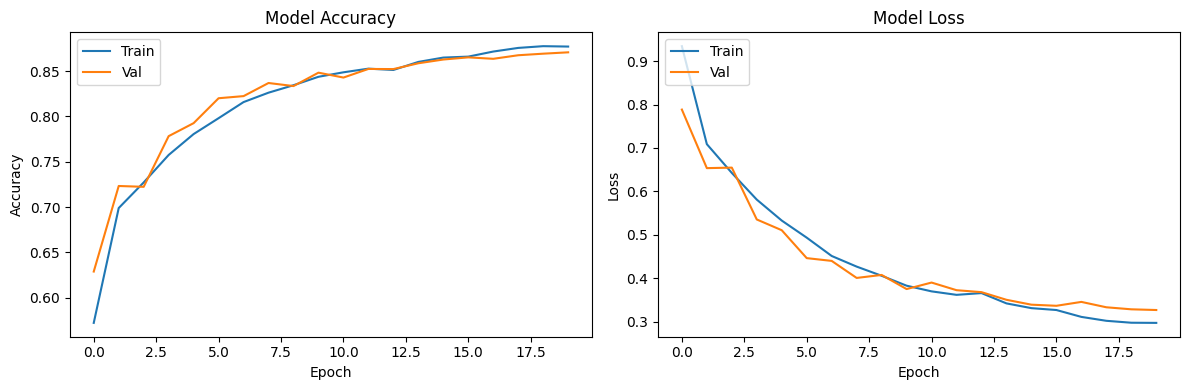

In [25]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
#Test Predictions

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


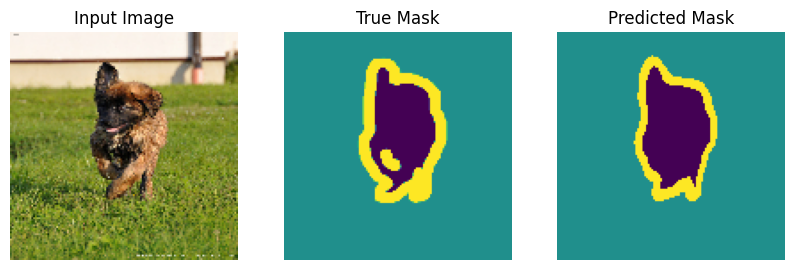

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


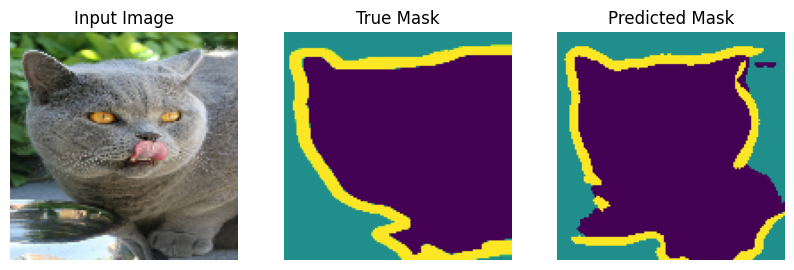

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


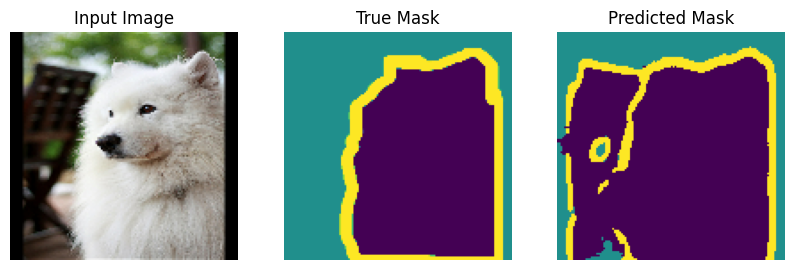

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


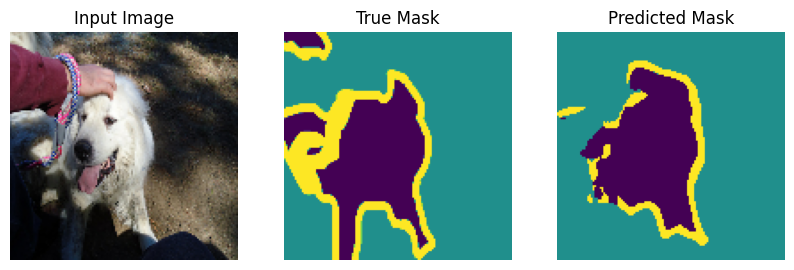

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


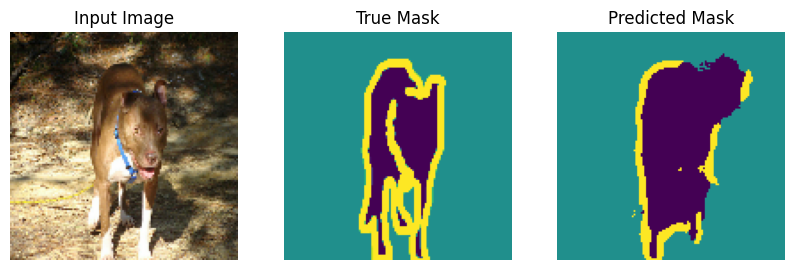

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


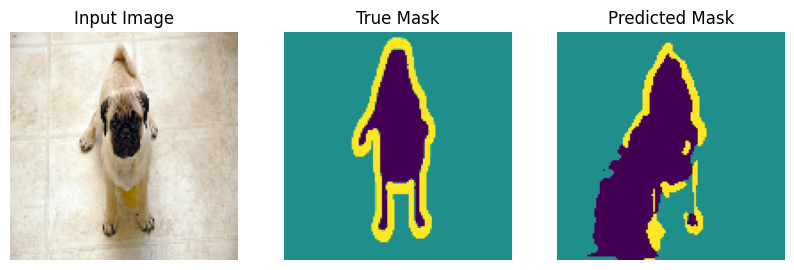

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


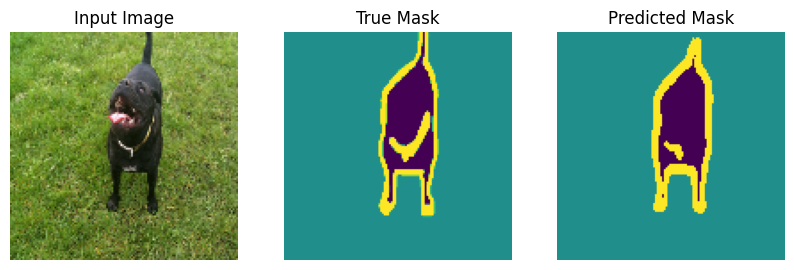

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


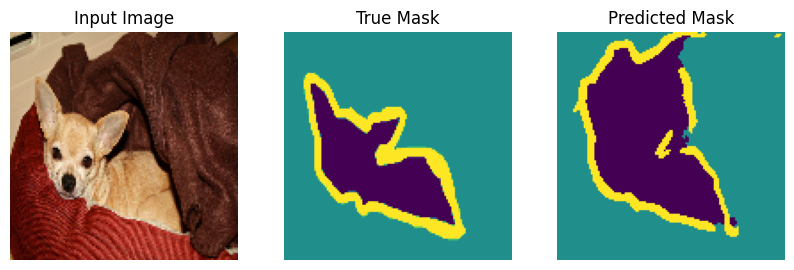

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


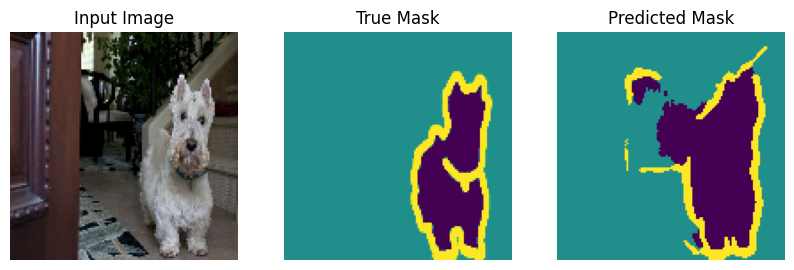

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


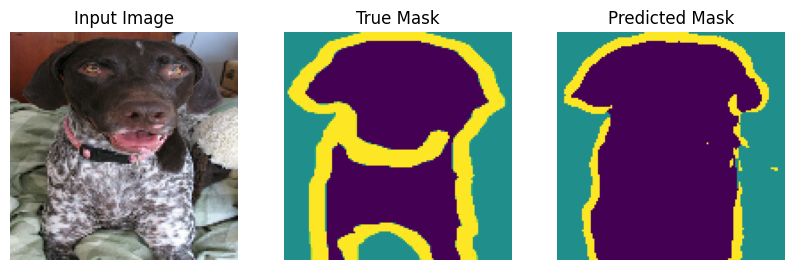

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


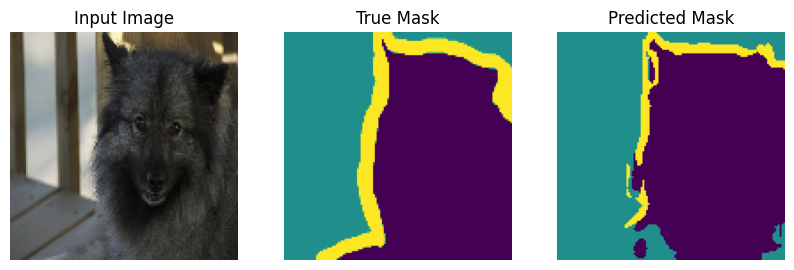

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


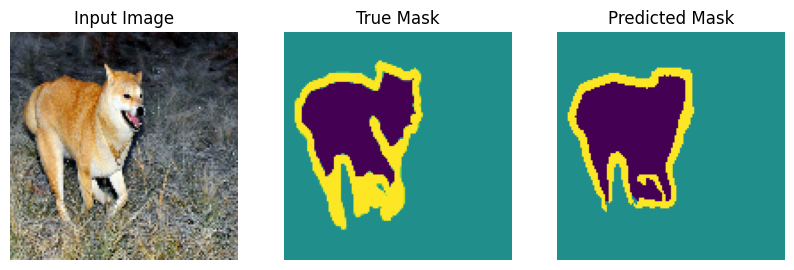

In [30]:
show_predictions(test_dataset, 12)